In [1]:
import LinearController
from StateGridPoints import *
from runBicycleTest import *
import time
from valueIteration import *
from LinearController import getLQRGains
from datetime import datetime
from matplotlib import colors

In [6]:
def calc_basin_of_attraction(controller, name, state_table_flag, v,
                             save = True):
    #state_table_flag is for the state table we will use to make the
    # grid points (ie, the controller may have been trained on a 
    #different one, but it will be plotted on state_table_flag)
    
    GridPoints = StateGridPoints()
    GridPoints.set_state_grid_points(state_table_flag)

  #with delta = 0

    phi_points, phi_dot_points,  delta_points = \
        np.meshgrid(GridPoints.phi_grid, GridPoints.phi_dot_grid,
                    [0.0])
    #if change delta from 0, think carefully about how
    #to mirror the points when plotting it
    
    phi_and_phi_dot_points= np.rec.fromarrays([phi_points, 
                                               phi_dot_points,
        delta_points], 
        names='phi_points,phi_dot_points, delta_points')
    
    print("calculating basis of attraction for controller " +
          name)
    success_array = np.zeros((GridPoints.len_phi_half_grid,
      GridPoints.len_phi_dot_grid))
     
    for (i, phi) in enumerate(GridPoints.phi_half_grid):

        print("phi: " + str(phi))
        for (j, phi_dot) in enumerate(GridPoints.phi_dot_grid):

            (success, _ ) = runBicycleTest(stateflag = None, 
                                           controller = controller,
            name = "", reward_flag = 14, simulation_duration= 2.0,
            isGraphing  = False, figObject = None, isPrinting = False,
            integrator_method = "fixed_step_RK4",
            USE_LINEAR_EOM = False, timestep = 1/50,
            starting_state3 = [phi, phi_dot, 0.0],
            v = v)

            success_array[i,j] = success
    
    if save:
        np.savetxt("BasinOfAttraction/"+ name 
                   + "_BasisOfAttraction.csv", success_array,
           delimiter = ",")

    
    return success_array

In [3]:
def load_basin(name):
    success_array = np.loadtxt("BasinOfAttraction/"+ name 
                   + "_BasisOfAttraction.csv",
           delimiter = ",")
    return success_array

In [53]:
def plot_basin_from_arrays(success_arrays, names, state_table_flag):
    #success_arrays is a list of arrays of successes each generated
    #with a call to 'calc_basin_of_attraction'
    n = len(success_arrays)
    fig1, ax1s = plt.subplots(1,n)
    
    GridPoints = StateGridPoints()
    GridPoints.set_state_grid_points(state_table_flag)
    
   
    
    difference_array = np.zeros((GridPoints.len_phi_grid, GridPoints.len_phi_dot_grid))
    
    ##### get line of constant energy? to plot (eigvector of A)
    xpoints = np.linspace(-GridPoints.len_phi_dot_grid//2, 
                          GridPoints.len_phi_dot_grid//2,11)
    
    ypoints = xpoints*(-0.223/0.975)*(
        2) #scale by 2 since phi_dot grid has 2x the spacing of phi grid
    #magic numbers from eigenvector of A w/ negative eigenvalue
#     ypoints = np.interp(ypoints_unscaled, 
#            (ypoints_unscaled.min(), ypoints_unscaled.max()),
#            (GridPoints.len_phi_half_grid*-1, 
#             GridPoints.len_phi_half_grid))
    
    #more origin to center
    xpoints = xpoints + GridPoints.len_phi_dot_grid//2
    ypoints = ypoints + GridPoints.len_phi_grid//2
    #####
    
    
    print("Success Graphs:")
    print("Red= failure, Green = success")
    for idx in range(n):
        success_array = success_arrays[idx]
        #print(np.shape(success_array))
        
        success_array = np.concatenate(
            (np.flip(success_array[1:,:],axis = (0,1)),
                     success_array[:,:]),
             axis = 0)
        #print(np.shape(success_array))       
        #define colormap
        cmap = colors.ListedColormap(['red','green'])
        bounds = [-0.5,0.5 ,1.5]
        norm= colors.BoundaryNorm(bounds, cmap.N)
        
        if idx==0:
            difference_array += success_array
        elif idx==1:
            difference_array -= success_array
        else:
            print("** Difference Array not computed for index " + str(idx))

        ax1 = ax1s[idx]

        max_phi = GridPoints.phi_grid[-1]
        max_phi_dot = GridPoints.phi_dot_grid[-1]
        im1 = ax1.imshow(success_array, cmap=cmap, norm = norm)
                        #extent = [-max_phi_dot, max_phi_dot,
                        #         -max_phi, max_phi] )
        ax1.set_title(str(names[idx])+" Basin of Attraction (delta = 0)")
        ax1.set_ylabel("lean [rad]")
        ax1.set_xlabel("lean rate [rad/s]")
        ax1.set_yticks(np.arange(GridPoints.len_phi_grid))
        ax1.set_xticks(np.arange(GridPoints.len_phi_dot_grid))
        ax1.set_yticklabels(np.around(GridPoints.phi_grid, decimals=2))
        ax1.set_xticklabels(np.around(GridPoints.phi_dot_grid, decimals = 2))

        ax1.plot(xpoints, ypoints, 'w')    
        
    fig2, ax2 = plt.subplots(1,1)
    #plot differences
    
    print("Differences Graph: ")
    colors_to_plot = ['yellow','white','purple']
    print(colors_to_plot[0]+": "+names[1]+" success only")
    print(colors_to_plot[1]+": both controllers same")
    print(colors_to_plot[2]+": "+names[0]+" success only")
    #define colormap
    cmap = colors.ListedColormap(colors_to_plot)
    bounds = [-1.5, -.5, .5 ,1.5]
    norm= colors.BoundaryNorm(bounds, cmap.N)
    
    im2 = ax2.imshow(difference_array,cmap = cmap, norm=norm)
    ax2.set_title(" Difference between " + str(names[0])+ " and " + str(names[1]))
    ax2.set_ylabel("lean [rad]")
    ax2.set_xlabel("lean rate [rad/s]")
    ax2.set_yticks(np.arange(GridPoints.len_phi_grid))
    ax2.set_xticks(np.arange(GridPoints.len_phi_dot_grid))
    ax2.set_yticklabels(np.around(GridPoints.phi_grid, decimals=2))
    ax2.set_xticklabels(np.around(GridPoints.phi_dot_grid, decimals = 2))
    
    ax2.plot(xpoints, ypoints, 'b')    
        
    plt.show()

In [23]:
#calc basin for 0.5m/s
name1 = "linear_0_5"
linear_0_5_SA = calc_basin_of_attraction(
    controller = LinearController.LinearController(
        getLQRGains("lqrd_0.5m_s")),
    name = name1, 
    state_table_flag = 16.2, 
    v = 0.5,
    save = True)

Using State Grid Flag 16.2
calculating basis of attraction for controller linear_0_5
phi: 0.0
phi: 0.02
phi: 0.04
phi: 0.06
phi: 0.08
phi: 0.1
phi: 0.12000000000000001
phi: 0.13999999999999999
phi: 0.16
phi: 0.18
phi: 0.19999999999999998
phi: 0.22
phi: 0.24
phi: 0.26
phi: 0.28
phi: 0.30000000000000004
phi: 0.32
phi: 0.34
phi: 0.36000000000000004
phi: 0.38
phi: 0.4
phi: 0.42000000000000004
phi: 0.44
phi: 0.46
phi: 0.48000000000000004
phi: 0.5
phi: 0.52
phi: 0.54
phi: 0.56
phi: 0.5800000000000001
phi: 0.6
phi: 0.62
phi: 0.64
phi: 0.66
phi: 0.68
phi: 0.7000000000000001
phi: 0.7200000000000001
phi: 0.74
phi: 0.76
phi: 0.78


In [24]:
#calc basin for 0.25m/s
name2 = "linear_0_25"
linear_0_25_SA = calc_basin_of_attraction(
    controller = LinearController.LinearController(
        getLQRGains("lqrd_0.25m_s")),
    name = name2, 
    state_table_flag = 16.2, 
    v = 0.25,
    save = True)

Using State Grid Flag 16.2
calculating basis of attraction for controller linear_0_25
phi: 0.0
phi: 0.02
phi: 0.04
phi: 0.06
phi: 0.08
phi: 0.1
phi: 0.12000000000000001
phi: 0.13999999999999999
phi: 0.16
phi: 0.18
phi: 0.19999999999999998
phi: 0.22
phi: 0.24
phi: 0.26
phi: 0.28
phi: 0.30000000000000004
phi: 0.32
phi: 0.34
phi: 0.36000000000000004
phi: 0.38
phi: 0.4
phi: 0.42000000000000004
phi: 0.44
phi: 0.46
phi: 0.48000000000000004
phi: 0.5
phi: 0.52
phi: 0.54
phi: 0.56
phi: 0.5800000000000001
phi: 0.6
phi: 0.62
phi: 0.64
phi: 0.66
phi: 0.68
phi: 0.7000000000000001
phi: 0.7200000000000001
phi: 0.74
phi: 0.76
phi: 0.78


In [36]:
v = 0.5

#name = "VI_r14_s6_a1"
#name = "VI_r14_a1_s16_v1_50episodes"
# name = "VI_r14_a1_s16_v0.5_100episodes"
name = "VI_r14_a1_s16_v0.5_100episodes"
#name = "VI_r14_a1_s16_v2_30episodes"
VI_model = ValueIteration(state_grid_flag = 16, action_grid_flag = 1,
reward_flag = 14, Ufile = "modelsB/"+name, use_only_continuous_actions = False,
remake_table = False, step_table_integration_method = "fixed_step_RK4",
USE_LINEAR_EOM = False, name = name, timestep = 1/50, v = v)


VI_model.init_controller(use_continuous_actions = True,
  use_continuous_state_with_discrete_actions = True,
  controller_integration_method = "fixed_step_RK4",
  use_regression_model_of_table = False)

name3 = "VI_0_5"

VI_0_5_SA = calc_basin_of_attraction(
    controller = VI_model,
    name = name3, 
    state_table_flag = 16.2, 
    v = v,
    save = True)

Initializing VI model
Using State Grid Flag 16
Loading step_table modelsB/VI_r14_a1_s16_v0.5_100episodes.csv from file


KeyboardInterrupt: 

In [66]:
success_arrays_loaded = [load_basin(name1),load_basin(name3)]

Using State Grid Flag 16.2
Success Graphs:
Red= failure, Green = success
Differences Graph: 
yellow: linear_0_25 success only
white: both controllers same
purple: linear_0_5 success only


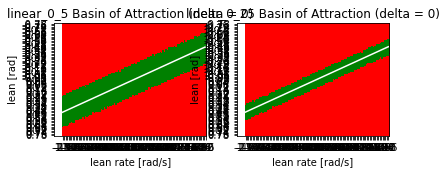

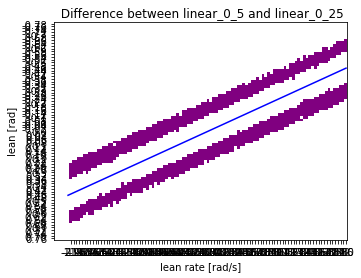

In [54]:
success_arrays_notloaded = [linear_0_5_SA, linear_0_25_SA]
plot_basin_from_arrays(success_arrays = success_arrays_notloaded ,
                       names = [name1, name2], 
                       state_table_flag = 16.2)